In [4]:
import os
import numpy as np

def load_data(directory, inp_size):
    #directory = "D:\\Users\\User\\Documents\\MLF_project\\MPA-MLF_data\\Train"
    files = os.listdir(directory)
    files.sort()

    train_data = np.zeros((len(files), inp_size[0], inp_size[1]))

    for file in files:
        if ".npy" in file:
            path = os.path.join(directory, file)
            train_data[files.index(file)] = np.load(path, "r")

    return train_data

def load_labels(path):
    labels = np.genfromtxt(path, delimiter=",")
    return labels[1:, 1]


def split_data(dataset: np.array, dataset_labels: np.array,  train_eval_ratio: float) -> tuple: 
    num_of_eval = np.int64(np.ceil(train_eval_ratio*dataset.shape[0]))
    print(num_of_eval)
    np.random.seed(0)
    np.random.shuffle(dataset)
    np.random.seed(0)
    np.random.shuffle(dataset_labels)
    
    rnd_test_index_list = np.random.choice(range(dataset.shape[0]), num_of_eval, replace = False)
    #rnd_test_index_list = np.random.randint(0, dataset.shape[0], num_of_eval)
    eval_labels = dataset_labels[rnd_test_index_list]
    eval = dataset[rnd_test_index_list]
    train = [dataset[k] for k in range(0,dataset.shape[0] - 1) if k not in rnd_test_index_list]
    train_labels = np.array([dataset_labels[k] for k in range(0,dataset_labels.shape[0] - 1) if k not in rnd_test_index_list])
    
    #train = dataset[train_index_list]
    return train, train_labels , eval, eval_labels

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, BatchNormalization, AveragePooling2D
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

In [6]:
dataset = load_data("C:\\Users\\Martin\\Documents\\REPO\\MPA-MLF\\Project\\MPA-MLF_DATA_NEW\\Train", (72, 48))
submition_data = load_data("C:\\Users\\Martin\\Documents\\REPO\\MPA-MLF\\Project\\MPA-MLF_DATA_NEW\\Test", (72, 48))
dataset_labels = load_labels("C:\\Users\\Martin\\Documents\\REPO\\MPA-MLF\\Project\\MPA-MLF_DATA_NEW\\label_train.csv")

####### DATA AUGMENTATION ########
bts_1 = dataset[dataset_labels == 1]
print("Num of bts 1: ", bts_1.shape[0])

bts_0 = dataset[dataset_labels == 0]
for k in range(2):
    bts_0 = bts_0 + np.random.normal(0, 3+k, (bts_0.shape[0], bts_0.shape[1], bts_0.shape[2])) #adding AWGN
    dataset = np.append(dataset, bts_0, 0)
    dataset_labels = np.append(dataset_labels, np.zeros(bts_0.shape[0]))
num_of_bts0 = np.count_nonzero(dataset_labels == 0)
print("Num of bts0: ", num_of_bts0)
print(num_of_bts0//bts_1.shape[0])

for k in range(num_of_bts0//bts_1.shape[0]):
    bts_1 = bts_1 + np.random.normal(0, 3+k//3, (bts_1.shape[0], bts_1.shape[1], bts_1.shape[2])) #adding AWGN
    dataset = np.append(dataset, bts_1, 0)
    dataset_labels = np.append(dataset_labels, np.ones(bts_1.shape[0]))

bts_2 = dataset[dataset_labels == 2]
print("Num of bts 2: ", bts_2.shape[0] )
for k in range(num_of_bts0//bts_2.shape[0]):
    bts_2 = bts_2 + np.random.normal(0, 3+k//3, (bts_2.shape[0], bts_2.shape[1], bts_2.shape[2])) #adding AWGN
    dataset = np.append(dataset, bts_2, 0)
    dataset_labels = np.append(dataset_labels, 2 * np.ones(bts_2.shape[0]))

print("Final size of dataset: ", dataset.shape)
print("Submition data size:", submition_data.shape)

Num of bts 1:  141
Num of bts0:  3627
25
Num of bts 2:  141
Final size of dataset:  (10959, 72, 48)
Submition data size: (120, 72, 48)


In [7]:
print(np.max(dataset), np.min(dataset))

x_train, y_train, x_test, y_test = extract_data.split_data(dataset, dataset_labels, 0.2)
x_sub = submition_data

print("Num of bts0, bts1, bts2 in training data: ", np.count_nonzero(y_train == 0), np.count_nonzero(y_train == 1), np.count_nonzero(y_train == 2), "num of train: ", len(y_train))
print("Num of bts0, bts1, bts2 in test data: ", np.count_nonzero(y_test == 0), np.count_nonzero(y_test == 1), np.count_nonzero(y_test == 2), "num of test: ", len(y_test))

y_train_encoded = to_categorical(y_train, num_classes=3)
y_test_encoded = to_categorical(y_test, num_classes=3)

x_train_mean = np.mean(x_train) #Z-score normalization of training data
x_train_deviation = np.std(x_train)
x_train_normalized = (x_train - x_train_mean) / x_train_deviation

x_test_mean = np.mean(x_test) #Z-score normalization of test data
x_test_deviation = np.std(x_test)
x_test_normalized = (x_test - x_test_mean) / x_test_deviation

x_sub_mean = np.mean(x_sub) #Z-score normalization of test data
x_sub_deviation = np.std(x_sub)
x_sub_normalized = (x_sub - x_sub_mean) / x_sub_deviation

#print(x_sub_normalized.shape)
x_train_normalized = x_train_normalized.reshape(-1, 72, 48, 1)
x_test_normalized = x_test_normalized.reshape(-1, 72, 48, 1)
x_sub_normalized = x_sub_normalized.reshape(-1, 72, 48, 1)
#print(x_sub_normalized.shape)

174.3473814249589 -219.6107599523046
2192
Num of bts0, bts1, bts2 in training data:  2892 2961 2913 num of train:  8766
Num of bts0, bts1, bts2 in test data:  734 705 753 num of test:  2192


In [8]:
model = Sequential()
#model.add(Input(x_train_normalized.shape))
model.add(Input(shape=(72, 48, 1)))
model.add(Conv2D(32, kernel_size=(5,5), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())#input_shape=(32, 32, 2)
#model.add(BatchNormalization())
model.add(Dense(64, activation='relu')) #128
model.add(Dense(32, activation='relu'))
#model.add(BatchNormalization())
model.add(Dense(3, activation='softmax'))


optimizer = Adam(learning_rate = 0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=7, verbose=1, restore_best_weights=True  )

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 68, 44, 32)     │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 34, 22, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 23936)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     1,531,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,534,979 (5.86 MB)

 Trainable params: 1,534,979 (5.86 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
history = model.fit(x_train_normalized, y_train_encoded, epochs=30, batch_size=20, validation_split = 0.2, callbacks = early_stopping)#, shuffle = True, validation_split = 0.2


Epoch 1/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.6503 - loss: 0.8238 - val_accuracy: 0.8523 - val_loss: 0.4776
Epoch 2/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.8788 - loss: 0.3824 - val_accuracy: 0.9048 - val_loss: 0.3107
Epoch 3/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.8804 - loss: 0.3365 - val_accuracy: 0.9327 - val_loss: 0.1902
Epoch 4/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9733 - loss: 0.0955 - val_accuracy: 0.9498 - val_loss: 0.1221
Epoch 5/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9388 - loss: 0.2833 - val_accuracy: 0.9048 - val_loss: 0.3563
Epoch 6/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9788 - loss: 0.0645 - val_accuracy: 0.8603 - val_loss: 0.5628
Epoch 7/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.9587 - loss: 0.2006 - val_accuracy: 0.9755 - val_loss: 0.0779
Epoch 8/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9988 - loss: 0.0090 - val_accu

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9724 - loss: 0.0595
Test loss: 0.06766824424266815
Test accuracy: 97.21715450286865 %


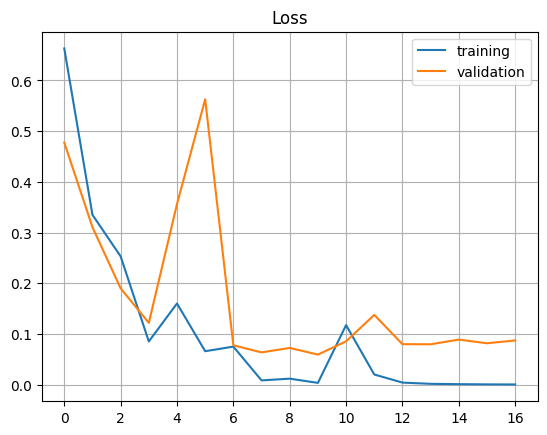

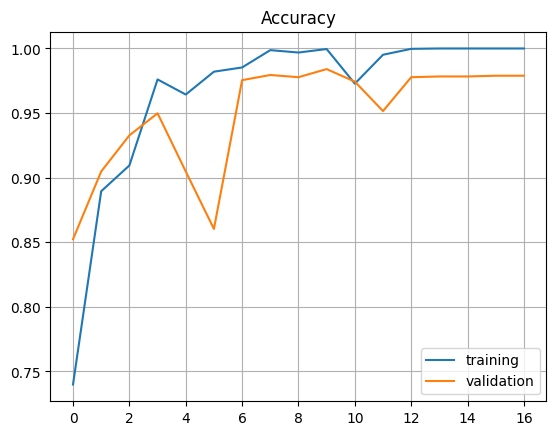

In [11]:
score = model.evaluate(x_test_normalized, y_test_encoded, verbose=1)
print('Test loss:', score[0])
print(f'Test accuracy: {score[1]*100} %')


#extract_data.load_data("MPA-MLF_data\Test", (72, 48))

plt.figure()
plt.title('Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.grid('both')
plt.figure()
plt.title('Accuracy')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.grid('both')

""" y_pred = model.predict(x_test_normalized)
#print(y_pred)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_encoded, axis=1)
#print(y_pred_classes)
#print(y_true_classes)
cm = confusion_matrix(y_true_classes, y_pred_classes)
print(cm)
ConfusionMatrixDisplay.from_predictions(y_true_classes,y_pred_classes)
plt.show() """

In [17]:
y_pred = model.predict(x_sub_normalized)
#print(y_pred)
y_pred_classes = np.argmax(y_pred, axis=1)
print(y_pred_classes)

import csv
with open('label_test_MT_v0.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['ID', 'target'])  # Write header
    for i, value in enumerate(y_pred_classes):
        writer.writerow([i, value])

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
[0 0 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0
 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 2 0 0 0 0 0
 0 0 0 0 1 0 0 0 2]
